# River data analysis

This notebook contains the data analysis for the Jamuna River given the available information (as of 23/02/2024). Excel files were provided by Erik Mosselman (Erik.Mosselman@deltares.nl). Some files are protected by copyright and cannot be shared in this repository. Please contact Antonio Magherini at *antonio.magherini@gmail.com* for info and access to these data.

These data represent daily, biweekly or monthly averages of water level, discharge and max velocity of the Jamuna River at different locations along the Bangladeshi reach (in downstream direction: Bahadurabad, Sirjganj - upstream of Jamuna Bridge, Aricha - confluence with Padma River).

In [1]:
# move to root directory

%cd .. 

c:\Users\anton\Desktop\jamunet-morpho-braided


In [2]:
# reload modules to avoid restarting the notebook every time these are updated

%load_ext autoreload
%autoreload 2

In [3]:
# import modules
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.ticker as ticker

from scipy.stats import kstest, expon, gumbel_r
from datetime import datetime

from preprocessing.river_analysis_pre import *
from postprocessing.river_analysis_post import *

%matplotlib inline

In [4]:
# set default plot parameters
plt.rcParams['figure.figsize'] = [17, 5]

plot_colors = ['blue', 'crimson', 'green', 'black', 'orange']
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=plot_colors)

The following notation is applied in this notebook. 

**Type of data recorded:** 

One of the following:
<ul>
  <li><code>WL</code> = Water Level (m)</li>
  <li><code>Q</code> = Discharge (m<sup>3</sup>/s)</li>
  <li><code>Umax</code> = Max Velocity (m/s)</li>
</ul>

**Interval of the record:**

One of the following:
<ul>
  <li><code>d</code> = daily</li>
  <li><code>w</code> = weekly</li>
  <li><code>bw</code> = biweekly</li>
  <li><code>m</code> = monthly</li>
</ul>



**Location of the record:** 

One of the following:
<ul>
  <li><code>Baha</code> = Bahadurabad</li>
  <li><code>Sir</code> = Sirajganj</li>
  <li><code>Ari</code> = Aricha</li>
</ul>



**Years of record:**

<code>xx_yy</code>, where
<ul>
  <li><code>xx</code> = initial year of record (last two digits)</li>
  <li><code>yy</code> = final year of record (last two digits)</li>
</ul>


Example: daily water level at Bahadurabad between 1964 and 2000 is <code>WL_d_Baha_64_00</code>.

If data are collected only during flood season (~May-October) then a suffix <code>_f</code> is added to the variable name, represnting the flood season.

Note on the reference system used for measuring the water level:

BWDB and other government departments refer water levels to the Public Works Datum (PWD). PWD is a horizontal datum believed originally to have zero at a determined Mean Sea Level (MSL) at Calcutta. PWD is located approx. 1.5 ft (~0.4572 m, A/N) below the MSL established in India under the British Rule and brought to Bangladesh during the Great Trigonometric Survey.

Retrieved from [Bangladesh Water Development Board (BWDB) website](http://www.ffwc.gov.bd/index.php/definitions).

In [5]:
# specify path of flow data 
path_flow_data = r'data/flow'

In [6]:
# set formats for dataframes data type
format_main = '%d/%m/%Y'
format_hours = '%d %B, %Y %I:%M:%p'
format_month = '%Y-%m'

# set formats for plotting 
format_day = '%b'
format_year = '%Y'

**<span style="color:red">Attention!</span> This record misses data from 24/09/1996 to 03/03/1997 and from 26/10/1999 to 01/01/2000 included. It also misses other few data but for shorter time intervals.**

In [7]:
Q_d_Baha_94_00 = load_Q_baha_94_00(r'/Daily_Q_Bahadurabad_1994-2000.xlsx', 9, [6,8],
                                   ['Date (yyyy-mm-dd)', r'Average daily discharge ($m^3/s$)'], format_main)
Q_d_Baha_94_00

,Date (yyyy-mm-dd),Average daily discharge ($m^3/s$)
0,1994-01-01,5930.00
1,1994-01-02,5870.00
2,1994-01-03,5770.00
3,1994-01-04,5720.00
4,1994-01-05,5680.00
...,...,...
2571,2000-12-20,6317.74
2572,2000-12-21,6429.74
2573,2000-12-22,6543.17
2574,2000-12-23,6636.11


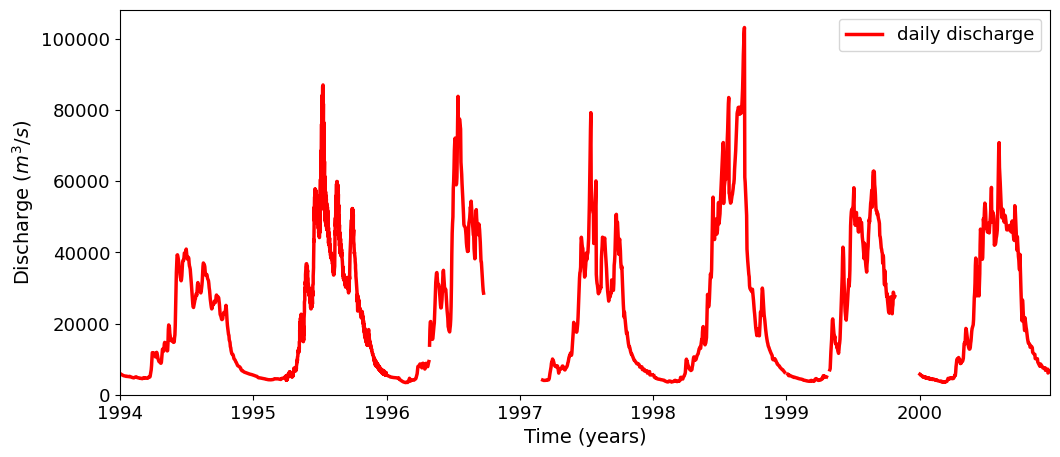

In [8]:
plot_exlcude_missing_data(Q_d_Baha_94_00, 'Q', 'Bahadurabad')

The following function is used to fill missing values with the average value computed across years in the same day.

In [9]:
Q_d_Baha_94_00_filled = fill_missing_data(Q_d_Baha_94_00, 'Average daily discharge ($m^3/s$)')
Q_d_Baha_94_00_filled

,Date (yyyy-mm-dd),Average daily discharge ($m^3/s$)
0,1994-01-01,5930.00
1,1994-01-02,5870.00
2,1994-01-03,5770.00
3,1994-01-04,5720.00
4,1994-01-05,5680.00
...,...,...
2820,2000-12-20,6317.74
2821,2000-12-21,6429.74
2822,2000-12-22,6543.17
2823,2000-12-23,6636.11


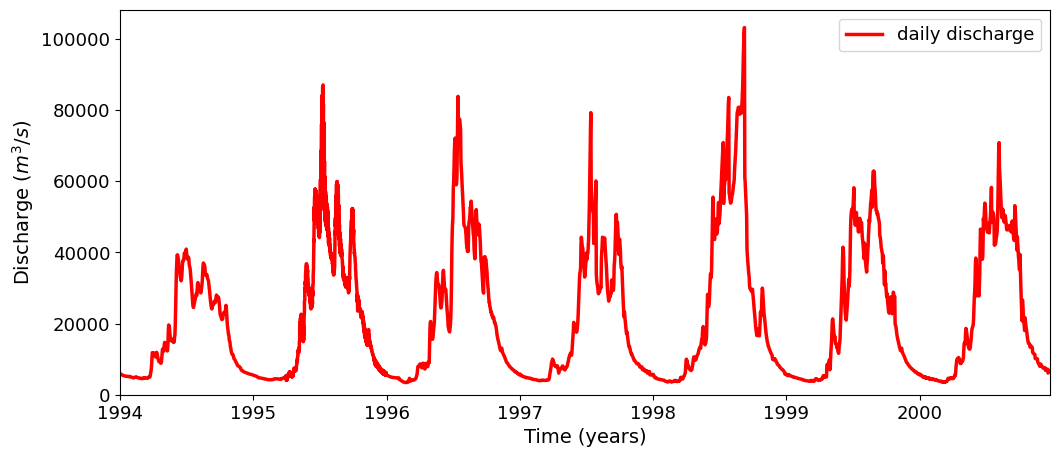

In [10]:
plot_exlcude_missing_data(Q_d_Baha_94_00_filled, 'Q', 'Bahadurabad', fill_missing=True)

**<span style="color:red">Attention!</span> This data are recorded according to the hydrological year, that is starting on 01/04 and ending on 31/03 of the next year. Therefore, considering column** <code>1964</code>**, the data from 01/04 up to 31/12 included were recorded in year 1964, while the data from 01/01 until 31/03 were recorded in 1965.**

**<span style="color:red">Attention!</span> This record misses the data the initial data of 1964 (from 01/01 to 31/03/1964), the 1971 hydrological year (01/04/1971-31/03/1972) due to war and the data from 01/08/1994 onwards.**

In [11]:
WL_d_Baha_64_94 = load_baha_69_94(r'/Daily_WL_Bahadurabad_1964-1994.xlsx')
WL_d_Baha_64_94

,Date (dd-mm),1964,1965,1966,1967,1968,1969,1970,1971,1972,...,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994
0,01-01,13.58,13.69,13.79,13.88,14.02,13.56,13.61,NaN,13.67,...,13.90,13.81,13.94,14.17,14.10,13.91,14.23,13.98,13.92,NaN
1,02-01,13.58,13.69,13.79,13.88,14.00,13.54,13.60,NaN,13.64,...,13.88,13.77,13.92,14.15,14.10,13.89,14.23,13.96,13.90,NaN
2,03-01,13.57,13.67,13.78,13.87,13.97,13.53,13.59,NaN,13.63,...,13.86,13.75,13.90,14.13,14.10,13.88,14.25,13.95,13.88,NaN
3,04-01,13.55,13.67,13.76,13.85,13.96,13.51,13.57,NaN,13.61,...,13.82,13.73,13.88,14.12,14.10,13.88,14.25,13.93,13.85,NaN
4,05-01,13.54,13.67,13.75,13.84,13.94,13.50,13.55,NaN,13.60,...,13.80,13.73,13.85,14.09,14.08,13.88,14.24,13.92,13.83,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
360,27-12,13.72,13.86,13.92,13.91,14.13,13.68,13.69,NaN,13.73,...,13.92,13.90,14.03,14.26,14.17,14.01,14.25,14.07,14.04,NaN
361,28-12,13.69,13.81,13.9,13.91,14.11,13.65,13.67,NaN,13.72,...,13.94,13.88,14.02,14.24,14.14,13.98,14.24,14.06,13.99,NaN
362,29-12,13.66,13.72,13.87,13.91,14.08,13.63,13.66,NaN,13.72,...,13.96,13.86,13.99,14.22,14.14,13.96,14.23,14.02,13.99,NaN
363,30-12,13.63,13.7,13.85,13.91,14.06,13.61,13.64,NaN,13.70,...,13.95,13.83,13.98,14.20,14.13,13.95,14.23,14.02,13.97,NaN


As it's possible to see from the dataframe, there are several <code>NaN</code> entries. In 1971 there was a war, therefore the whole year misses the daily records of water level. In 1994 only data between April 1 and July 31 were recorded.

In the following cells these <code>NaN</code> values are replaced with the average value across the years for each specific day in which the data is missing.

In [12]:
WL_d_Baha_64_94 = fill_na(WL_d_Baha_64_94, axis=1)
WL_d_Baha_64_94

,Date (dd-mm),1964,1965,1966,1967,1968,1969,1970,1971,1972,...,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994
0,01-01,13.58,13.69,13.79,13.88,14.02,13.56,13.61,13.84,13.67,...,13.90,13.81,13.94,14.17,14.10,13.91,14.23,13.98,13.92,13.84
1,02-01,13.58,13.69,13.79,13.88,14.00,13.54,13.60,13.82,13.64,...,13.88,13.77,13.92,14.15,14.10,13.89,14.23,13.96,13.90,13.82
2,03-01,13.57,13.67,13.78,13.87,13.97,13.53,13.59,13.81,13.63,...,13.86,13.75,13.90,14.13,14.10,13.88,14.25,13.95,13.88,13.81
3,04-01,13.55,13.67,13.76,13.85,13.96,13.51,13.57,13.79,13.61,...,13.82,13.73,13.88,14.12,14.10,13.88,14.25,13.93,13.85,13.79
4,05-01,13.54,13.67,13.75,13.84,13.94,13.50,13.55,13.78,13.60,...,13.80,13.73,13.85,14.09,14.08,13.88,14.24,13.92,13.83,13.78
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
360,27-12,13.72,13.86,13.92,13.91,14.13,13.68,13.69,13.93,13.73,...,13.92,13.90,14.03,14.26,14.17,14.01,14.25,14.07,14.04,13.93
361,28-12,13.69,13.81,13.90,13.91,14.11,13.65,13.67,13.91,13.72,...,13.94,13.88,14.02,14.24,14.14,13.98,14.24,14.06,13.99,13.91
362,29-12,13.66,13.72,13.87,13.91,14.08,13.63,13.66,13.89,13.72,...,13.96,13.86,13.99,14.22,14.14,13.96,14.23,14.02,13.99,13.89
363,30-12,13.63,13.70,13.85,13.91,14.06,13.61,13.64,13.87,13.70,...,13.95,13.83,13.98,14.20,14.13,13.95,14.23,14.02,13.97,13.87


In [13]:
max_values_6494 = WL_d_Baha_64_94.max()
max_values_6494

Date (dd-mm)    31-12
1964            19.84
1965            19.69
1966            19.62
1967             19.5
1968             19.8
1969            19.84
1970             20.2
1971            19.06
1972            19.98
1973            19.88
1974            20.26
1975             19.6
1976            19.87
1977            19.99
1978            19.63
1979            19.78
1980             20.1
1981            19.48
1982            19.42
1983            19.92
1984             20.1
1985            19.61
1986            19.15
1987            19.68
1988            20.61
1989            19.57
1990            19.38
1991            20.08
1992            19.17
1993            19.91
1994            19.05
dtype: object

In [14]:
# visualize full DataFrame - uncomment if needed
# print(WL_d_Baha_64_94.to_markdown())

In [15]:
# compute daily means across years
WL_d_Baha_64_94_dmeans = pd.DataFrame(WL_d_Baha_64_94['Date (dd-mm)'])
WL_d_Baha_64_94_dmeans['Average daily water level (m)'] = pd.DataFrame(np.mean(WL_d_Baha_64_94, axis=1))
# WL_d_Baha_64_94_dmeans

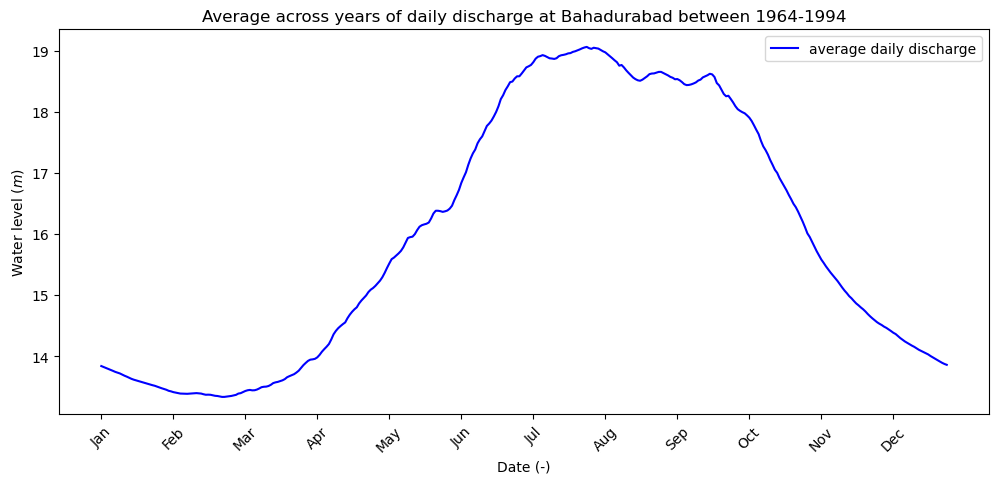

In [16]:
plot_avgQ(WL_d_Baha_64_94_dmeans)

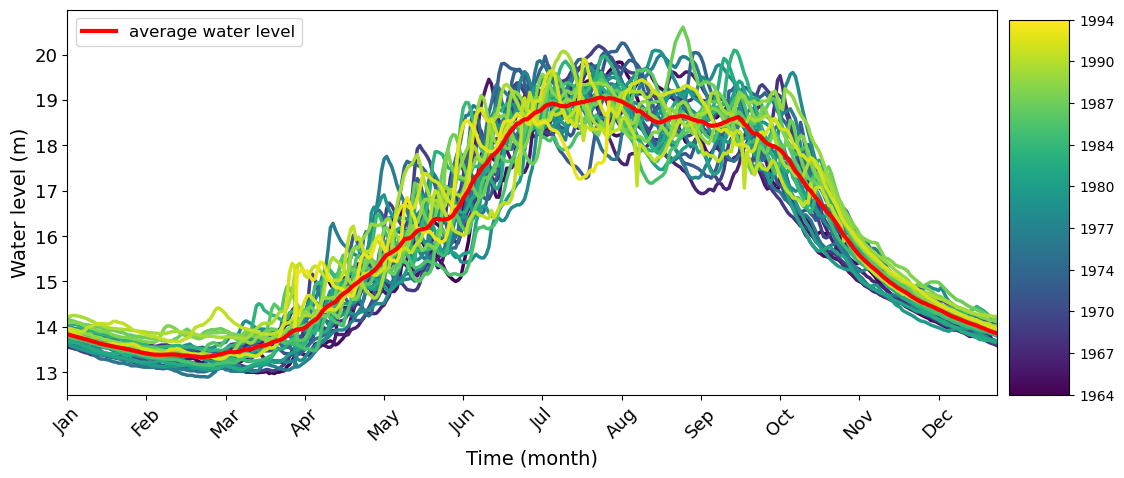

In [17]:
plot_all_years(WL_d_Baha_64_94, save_img=False)

In [18]:
# create date array starting from 01/04/1964 until 31/03/1995 (years of record)
start_date = datetime(1964, 4, 1)
end_date = datetime(1995, 3, 31) 
time_interval = pd.date_range(start=start_date, end=end_date, freq='D')

# filter out 29/02 from array
time_interval = time_interval[~((time_interval.month == 2) & (time_interval.day == 29))]

In [19]:
WL_d_Baha_64_94_reshaped = reshape_df(WL_d_Baha_64_94, time_interval, format_main)
WL_d_Baha_64_94_reshaped

,Date (yyyy-mm-dd),Average daily water level (m)
0,1964-04-01,13.58
1,1964-04-02,13.58
2,1964-04-03,13.57
3,1964-04-04,13.55
4,1964-04-05,13.54
...,...,...
11310,1995-03-27,13.93
11311,1995-03-28,13.91
11312,1995-03-29,13.89
11313,1995-03-30,13.87


In [20]:
# get specified percentile values
wl_stats = WL_d_Baha_64_94_reshaped['Average daily water level (m)'].describe(
    percentiles=[0.25, 0.5, 0.75, 0.90, 0.95]
)

# extract water level statistical values
min_wl = wl_stats['min']
q1_wl = wl_stats['25%']
median_wl = wl_stats['50%']
mean_wl = wl_stats['mean']
q3_wl = wl_stats['75%']
q90_wl = wl_stats['90%']
q95_wl = wl_stats['95%']
max_wl = wl_stats['max']

wls = [min_wl, q1_wl, median_wl, mean_wl, q3_wl, q90_wl, q95_wl, max_wl]
print(wls)

[12.89, 13.91, 15.53, 15.967788775961116, 18.16, 18.95, 19.25, 20.61]


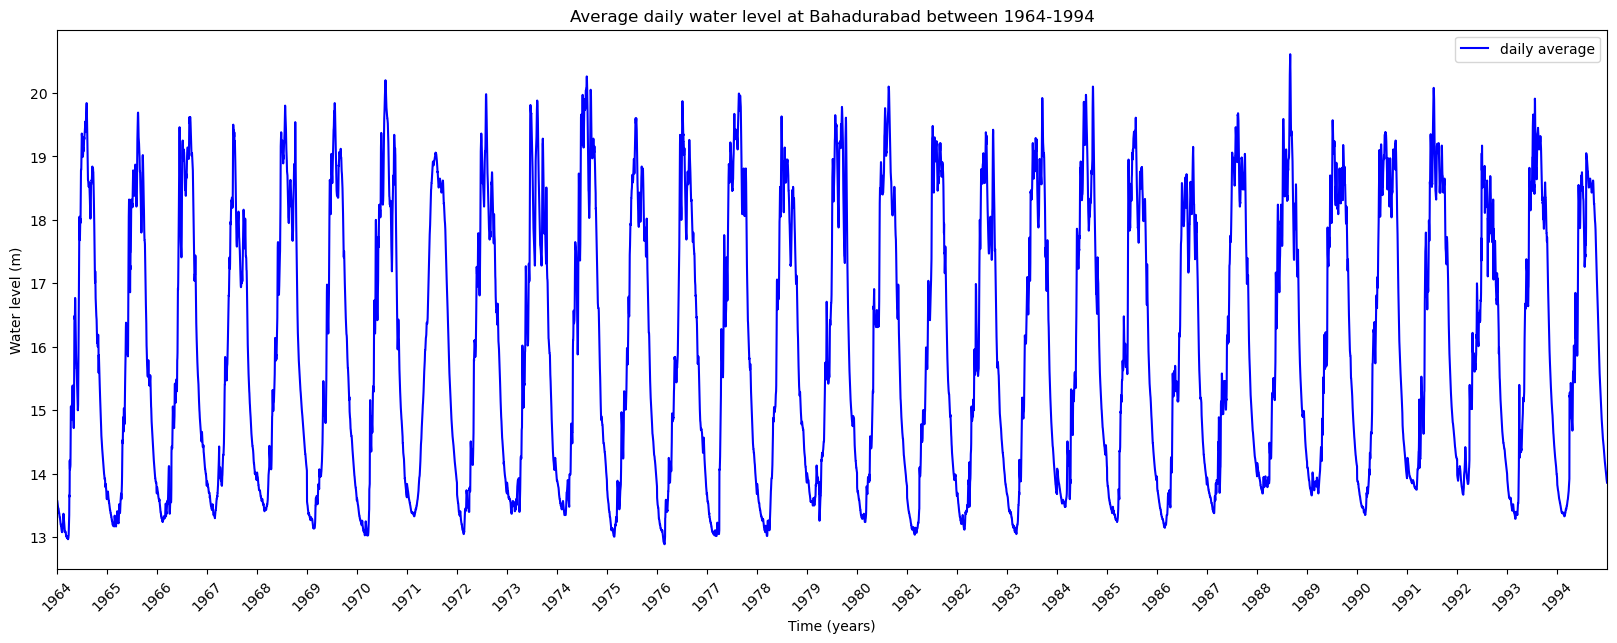

In [21]:
plot(WL_d_Baha_64_94_reshaped)

In [22]:
WL_d_Baha_94_00 = pd.read_excel(path_flow_data + r'/Daily_WL_Bahadurabad_1994-2000.xlsx', header=9, usecols=[8, 9])
WL_d_Baha_94_00.columns = ['Date (yyyy-mm-dd)', 'Average daily water level (m)']
WL_d_Baha_94_00['Date (yyyy-mm-dd)'] = pd.to_datetime(WL_d_Baha_94_00['Date (yyyy-mm-dd)'], 
                                                      format='%d %B, %Y %I:%M:%p').dt.date # change to date-time format and keep only the date (discard hour and minute)  
WL_d_Baha_94_00

,Date (yyyy-mm-dd),Average daily water level (m)
0,1994-01-01,13.92
1,1994-01-02,13.90
2,1994-01-03,13.87
3,1994-01-04,13.85
4,1994-01-05,13.83
...,...,...
9496,2000-12-31,13.84
9497,2000-12-31,13.84
9498,2000-12-31,13.83
9499,2000-12-31,13.83


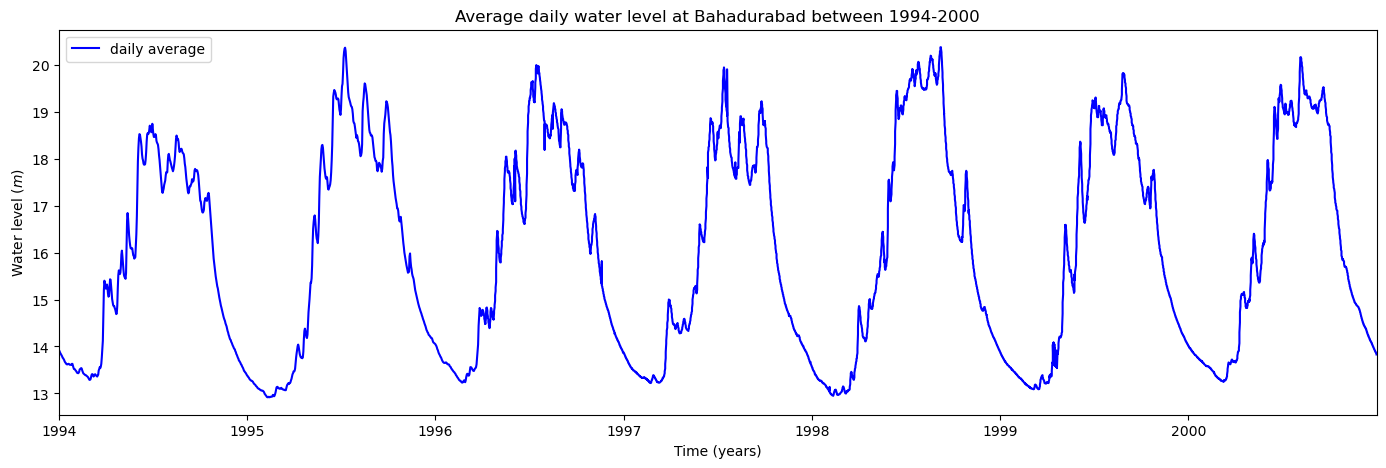

In [23]:
plot_WL_9400(WL_d_Baha_94_00)

In [24]:
Q_m_Baha_94_00 = load_baha_94_00(r'/Monthly_Q_Bahadurabad_1994-2000.xlsx', 9, [7, 8, 9, 10, 11], 
                                [r'Monthly max discharge ($m^3/s$)', r'Monthly min discharge ($m^3/s$)', 
                                r'Monthly average discharge ($m^3/s$)', 'Date (yyyy-mm-dd)'], '%Y-%m')

Q_m_Baha_94_00

,Date (yyyy-mm-dd),Monthly max discharge ($m^3/s$),Monthly min discharge ($m^3/s$),Monthly average discharge ($m^3/s$)
0,1994-01-01,5920.00,4980.00,5312.96
1,1994-02-01,5010.00,4550.00,4793.04
2,1994-03-01,11800.00,4510.00,5908.64
3,1994-04-01,12800.00,8880.00,10827.92
4,1994-05-01,19600.00,12300.00,15263.64
...,...,...,...,...
76,2000-08-01,69320.37,45887.58,53215.30
77,2000-09-01,49921.63,38092.32,44339.46
78,2000-10-01,32234.34,13668.67,19360.01
79,2000-11-01,12720.17,7681.41,10423.39


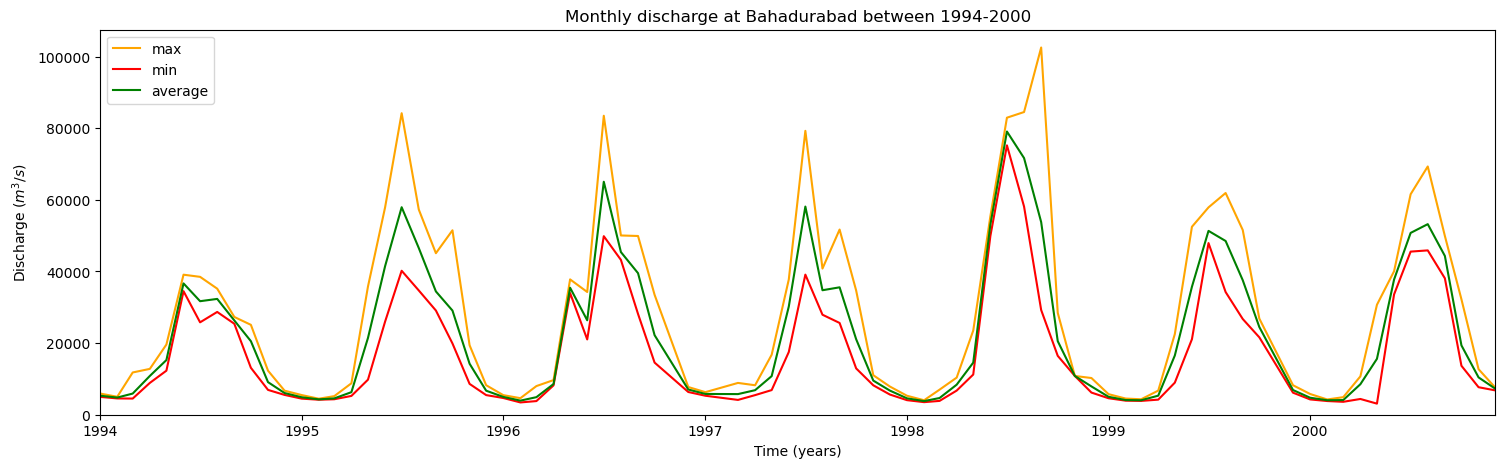

In [25]:
plot_monthlyQs(Q_m_Baha_94_00)

**<span style="color:red">Attention!</span> This record misses the data from 01/10 to 31/10/2012, from 01/05 to 30/06/2013, from 01/02 to 31/05/2014 and other smaller intervals.**

In [26]:
file_big_excel = r'/Daily_WL_Sirajganj_2006-2022_Biweekly_WL_Q_Umax_Bahadurabad_1990-2016.xlsx'

WL_d_Baha_12_22 = pd.read_excel(path_flow_data + file_big_excel, sheet_name='Bahadurabad WL', header=0, usecols=[3, 4, 5])
WL_d_Baha_12_22.rename(columns={WL_d_Baha_12_22.columns[2]: 'Date (yyyy-mm-dd)'}, inplace=True)
WL_d_Baha_12_22.drop(axis=0, index=0, inplace=True)
WL_d_Baha_12_22.reset_index(drop=True, inplace=True)

# compute daily average
WL_d_Baha_12_22['Average daily water level (m)'] = np.mean([WL_d_Baha_12_22['HighTide'], WL_d_Baha_12_22['LowTide']], axis=0).round(2)

WL_d_Baha_12_22.drop(axis='columns', columns=WL_d_Baha_12_22.columns[:2], inplace=True)
Q_d_Baha_94_00['Date (yyyy-mm-dd)'] = pd.to_datetime(Q_d_Baha_94_00['Date (yyyy-mm-dd)'], format='%d/%m/%Y')
WL_d_Baha_12_22

,Date (yyyy-mm-dd),Average daily water level (m)
0,2012-01-01,13.27
1,2012-01-02,13.24
2,2012-01-03,13.22
3,2012-01-04,13.21
4,2012-01-05,13.20
...,...,...
3709,2022-11-26,13.77
3710,2022-11-27,13.71
3711,2022-11-28,13.68
3712,2022-11-29,13.62


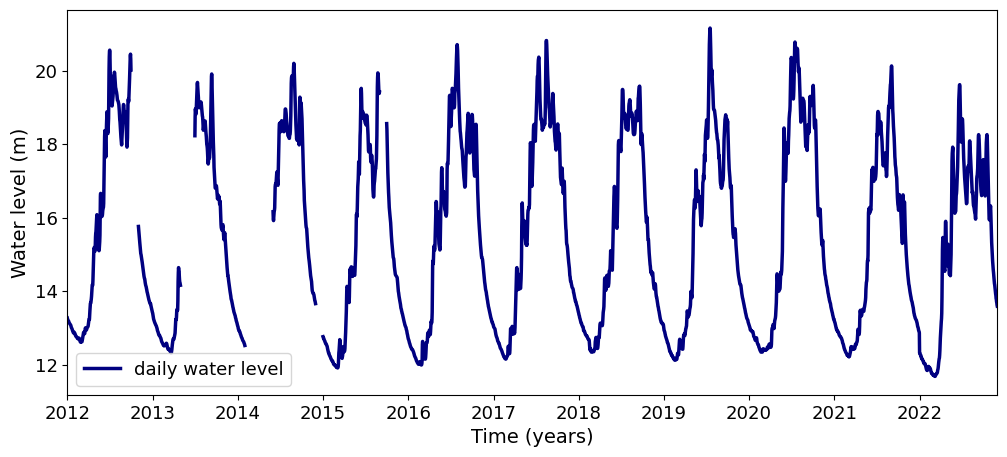

In [27]:
plot_exlcude_missing_data(WL_d_Baha_12_22, 'WL', 'Bahadurabad')

In [28]:
WL_d_Baha_12_22_filled = fill_missing_data(WL_d_Baha_12_22, 'Average daily water level (m)')
WL_d_Baha_12_22_filled

,Date (yyyy-mm-dd),Average daily water level (m)
0,2012-01-01,13.27
1,2012-01-02,13.24
2,2012-01-03,13.22
3,2012-01-04,13.21
4,2012-01-05,13.20
...,...,...
3982,2022-11-26,13.77
3983,2022-11-27,13.71
3984,2022-11-28,13.68
3985,2022-11-29,13.62


In [29]:
max_wl_1222 = WL_d_Baha_12_22_filled.groupby(WL_d_Baha_12_22_filled['Date (yyyy-mm-dd)'].dt.year)['Average daily water level (m)'].max().reset_index()
max_wl_1222

,Date (yyyy-mm-dd),Average daily water level (m)
0,2012,20.56
1,2013,19.91
2,2014,20.20
3,2015,19.94
4,2016,20.71
5,2017,20.82
6,2018,19.58
7,2019,21.16
8,2020,20.78
9,2021,20.13


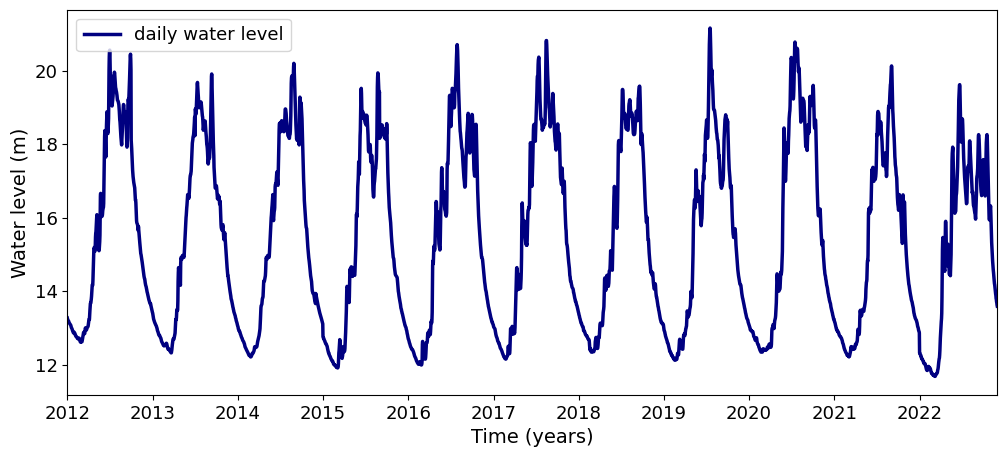

In [30]:
plot_exlcude_missing_data(WL_d_Baha_12_22_filled, 'WL', 'Bahadurabad', fill_missing=True, save_img=False)

In [31]:
file_big_excel = r'/Daily_WL_Sirajganj_2006-2022_Biweekly_WL_Q_Umax_Bahadurabad_1990-2016.xlsx'

WL_Q_Umax_bi_Baha_90_16 = pd.read_excel(path_flow_data + file_big_excel, sheet_name='Bahadurabad Discharge', header=0, usecols=[3, 4, 5, 6])
WL_Q_Umax_bi_Baha_90_16.columns = ['Date (yyyy-mm-dd)', 'Biweekly water level (m)', r'Biweekly discharge ($m^3/s$)', 'Biweekly max velocity (m/s)']
WL_Q_Umax_bi_Baha_90_16.reset_index(drop=True, inplace=True)
WL_Q_Umax_bi_Baha_90_16['Date (yyyy-mm-dd)'] = pd.to_datetime(WL_Q_Umax_bi_Baha_90_16['Date (yyyy-mm-dd)'], format='%d/%m/%Y')
WL_Q_Umax_bi_Baha_90_16

,Date (yyyy-mm-dd),Biweekly water level (m),Biweekly discharge ($m^3/s$),Biweekly max velocity (m/s)
0,1990-01-08,14.00,6480.00,1.00
1,1990-01-22,13.77,5930.00,1.00
2,1990-02-05,13.71,5340.00,1.00
3,1990-02-19,13.77,5510.00,1.00
4,1990-03-05,13.86,6330.00,1.00
...,...,...,...,...
2058,2016-10-25,16.86,23118.90,1.45
2059,2016-11-08,15.15,13708.81,1.07
2060,2016-11-23,14.36,12774.34,0.98
2061,2016-12-06,13.77,6727.21,0.77


In [32]:
max_wl_per_year = WL_Q_Umax_bi_Baha_90_16.groupby(WL_Q_Umax_bi_Baha_90_16['Date (yyyy-mm-dd)'].dt.year)['Biweekly water level (m)'].max().reset_index()
max_wl_per_year

,Date (yyyy-mm-dd),Biweekly water level (m)
0,1990,19.350
1,1991,19.170
2,1992,19.110
3,1993,19.390
4,1994,18.510
5,1995,20.180
6,1996,19.918
7,1997,19.802
8,1998,20.280
9,1999,19.700


In [33]:
# group data by year and get index of max value per year
max_discharge_per_year = WL_Q_Umax_bi_Baha_90_16.groupby(
    WL_Q_Umax_bi_Baha_90_16['Date (yyyy-mm-dd)'].dt.year)[
        'Biweekly discharge ($m^3/s$)'].max().reset_index()

In [34]:
max_discharge_per_year

,Date (yyyy-mm-dd),Biweekly discharge ($m^3/s$)
0,1990,64400.00
1,1991,61500.00
2,1992,65600.00
3,1993,59100.00
4,1994,39100.00
5,1995,84200.00
6,1996,83485.00
7,1997,79270.00
8,1998,102535.00
9,1999,61915.00


In [35]:
# get specified percentile values
discharge_stats = WL_Q_Umax_bi_Baha_90_16['Biweekly discharge ($m^3/s$)'].describe(
    percentiles=[0.25, 0.5, 0.75, 0.90, 0.95]
)

# extract discharge statistical values
min_disch = discharge_stats['min']
q1_disch = discharge_stats['25%']
median_disch = discharge_stats['50%']
mean_disch = discharge_stats['mean']
q3_disch = discharge_stats['75%']
q90_disch = discharge_stats['90%']
q95_disch = discharge_stats['95%']
max_disch = discharge_stats['max']

In [36]:
# locate 
min_water_level = WL_Q_Umax_bi_Baha_90_16.loc[
    (WL_Q_Umax_bi_Baha_90_16['Biweekly discharge ($m^3/s$)'] - min_disch).abs().idxmin(),
    'Biweekly water level (m)'
]

q1_water_level = WL_Q_Umax_bi_Baha_90_16.loc[
    (WL_Q_Umax_bi_Baha_90_16['Biweekly discharge ($m^3/s$)'] - q1_disch).abs().idxmin(),
    'Biweekly water level (m)'
]

median_water_level = WL_Q_Umax_bi_Baha_90_16.loc[
    (WL_Q_Umax_bi_Baha_90_16['Biweekly discharge ($m^3/s$)'] - median_disch).abs().idxmin(),
    'Biweekly water level (m)'
]

mean_water_level = WL_Q_Umax_bi_Baha_90_16.loc[
    (WL_Q_Umax_bi_Baha_90_16['Biweekly discharge ($m^3/s$)'] - mean_disch).abs().idxmin(),
    'Biweekly water level (m)'
]

q3_water_level = WL_Q_Umax_bi_Baha_90_16.loc[
    (WL_Q_Umax_bi_Baha_90_16['Biweekly discharge ($m^3/s$)'] - q3_disch).abs().idxmin(),
    'Biweekly water level (m)'
]

q90_water_level = WL_Q_Umax_bi_Baha_90_16.loc[
    (WL_Q_Umax_bi_Baha_90_16['Biweekly discharge ($m^3/s$)'] - q90_disch).abs().idxmin(),
    'Biweekly water level (m)'
]


q95_water_level = WL_Q_Umax_bi_Baha_90_16.loc[
    (WL_Q_Umax_bi_Baha_90_16['Biweekly discharge ($m^3/s$)'] - q95_disch).abs().idxmin(),
    'Biweekly water level (m)'
]

max_water_level = WL_Q_Umax_bi_Baha_90_16.loc[
    (WL_Q_Umax_bi_Baha_90_16['Biweekly discharge ($m^3/s$)'] - max_disch).abs().idxmin(),
    'Biweekly water level (m)'
]

In [37]:
WL_Q_Umax_bi_Baha_90_16['Date (yyyy-mm-dd)'].iloc[0]

Timestamp('1990-01-08 00:00:00')

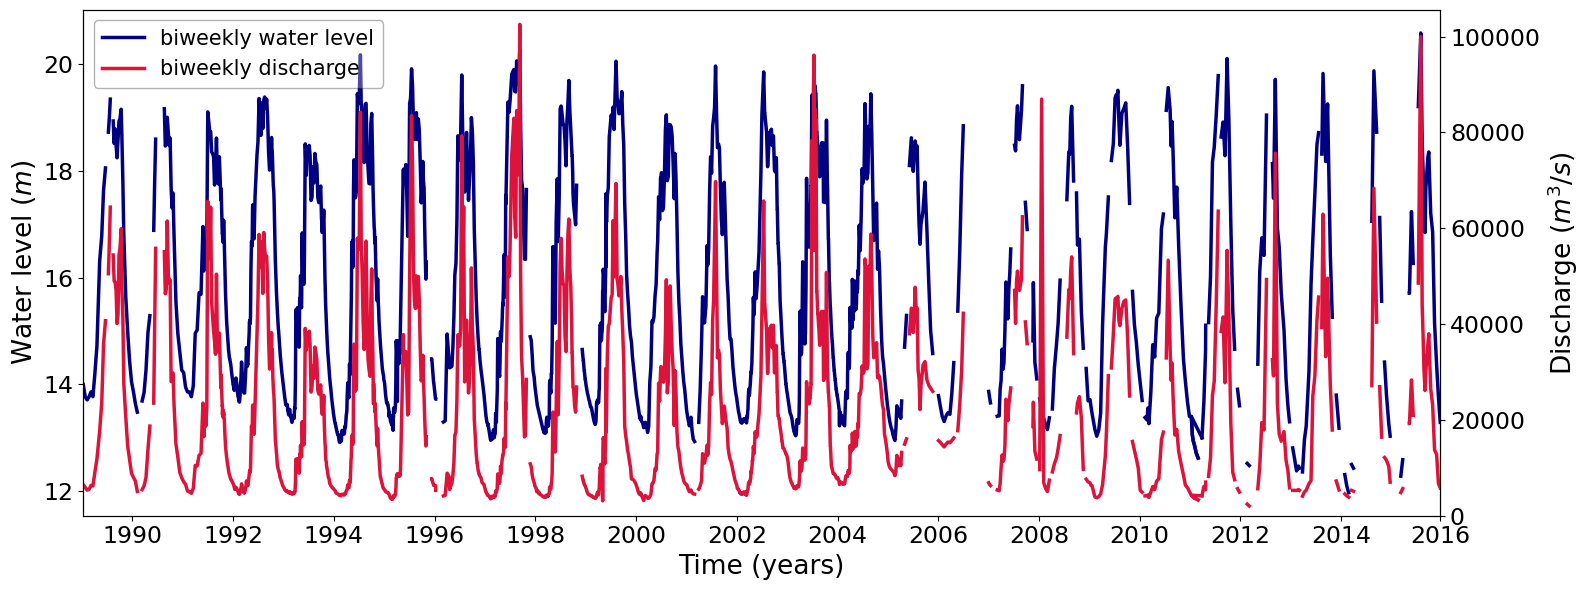

In [38]:
import matplotlib.dates as mdates
plt.rcParams['lines.linewidth'] = 2.5
fig, ax1 = plt.subplots(figsize=[16, 6])

plt.tick_params(axis='both', which='major', labelsize=17)  # Major ticks
plt.tick_params(axis='both', which='minor', labelsize=12)

start_idx = 0
for i in range(1, len(WL_Q_Umax_bi_Baha_90_16['Date (yyyy-mm-dd)'])):
    # if next observation is not 1 day after previous the plotted line is stopped 
    if WL_Q_Umax_bi_Baha_90_16['Date (yyyy-mm-dd)'].iloc[i] - WL_Q_Umax_bi_Baha_90_16['Date (yyyy-mm-dd)'].iloc[i-1] > np.timedelta64(20, 'D'): 
        plt.plot(WL_Q_Umax_bi_Baha_90_16['Date (yyyy-mm-dd)'].iloc[start_idx:i], WL_Q_Umax_bi_Baha_90_16['Biweekly water level (m)'].iloc[start_idx:i], color='navy')
        start_idx = i
plt.plot(WL_Q_Umax_bi_Baha_90_16['Date (yyyy-mm-dd)'].iloc[start_idx:], WL_Q_Umax_bi_Baha_90_16['Biweekly water level (m)'].iloc[start_idx:], 
         color='navy', label='biweekly water level')


ax1.set_xlabel('Time (years)', fontsize=19)
ax1.set_ylabel(r'Water level ($m$)', fontsize=19)
# ax1.plot(WL_Q_Umax_bi_Baha_90_16['Date (yyyy-mm-dd)'], WL_Q_Umax_bi_Baha_90_16['Biweekly water level (m)'], color='blue', label='water level')

# Set x-ticks every two years using pandas date_range
min_date = WL_Q_Umax_bi_Baha_90_16['Date (yyyy-mm-dd)'].min()
max_date = WL_Q_Umax_bi_Baha_90_16['Date (yyyy-mm-dd)'].max()

# Create a date range with 2-year frequency
date_range = pd.date_range(start=min_date, end=max_date, freq='2Y')

# Include the maximum date as an extra tick if it is not already in the date_range
if max_date not in date_range:
    date_range = date_range.append(pd.Index([max_date]))

# Set the x-ticks
ax1.set_xticks(date_range)
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y')) 

# # Creating a secondary y-axis
ax2 = ax1.twinx()
ax2.set_ylabel(r'Discharge ($m^3/s$)', fontsize=19)
ax2.set_ylim([0, WL_Q_Umax_bi_Baha_90_16[r'Biweekly discharge ($m^3/s$)'].max()+3000])
start_idx = 0
for i in range(1, len(WL_Q_Umax_bi_Baha_90_16['Date (yyyy-mm-dd)'])):
    # if next observation is not 1 day after previous the plotted line is stopped 
    if WL_Q_Umax_bi_Baha_90_16['Date (yyyy-mm-dd)'].iloc[i] - WL_Q_Umax_bi_Baha_90_16['Date (yyyy-mm-dd)'].iloc[i-1] > np.timedelta64(20, 'D'): 
        ax2.plot(WL_Q_Umax_bi_Baha_90_16['Date (yyyy-mm-dd)'].iloc[start_idx:i], WL_Q_Umax_bi_Baha_90_16[r'Biweekly discharge ($m^3/s$)'].iloc[start_idx:i], color='crimson')
        start_idx = i
ax2.plot(WL_Q_Umax_bi_Baha_90_16['Date (yyyy-mm-dd)'].iloc[start_idx:], WL_Q_Umax_bi_Baha_90_16[r'Biweekly discharge ($m^3/s$)'].iloc[start_idx:], 
         color='crimson', label='biweekly discharge')
ax2.tick_params(axis='both', which='major', labelsize=17)  # Adjust major ticks for twin axis
ax2.tick_params(axis='both', which='minor', labelsize=12) 
# ax2.plot(WL_Q_Umax_bi_Baha_90_16['Date (yyyy-mm-dd)'], WL_Q_Umax_bi_Baha_90_16[r'Biweekly discharge ($m^3/s$)'], color='crimson', label='discharge')

# plt.title('Biweekly daily water level and discharge at Bahadurabad between 1990-2016')
plt.xlim([WL_Q_Umax_bi_Baha_90_16['Date (yyyy-mm-dd)'].min(), WL_Q_Umax_bi_Baha_90_16['Date (yyyy-mm-dd)'].max()])

# include both labels in legend
handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
handles = handles1 + handles2
labels = labels1 + labels2
plt.legend(handles, labels, framealpha=0.3,  # loc='lower left' # for rotated image!
              frameon=True, edgecolor='black', fontsize=15, loc='upper left')
plt.tight_layout()
# plt.savefig(r'images\report\10_appendix\river\wl_disch.png', dpi=300, bbox_inches='tight')  # Save as PNG with 300 dpi
plt.show()

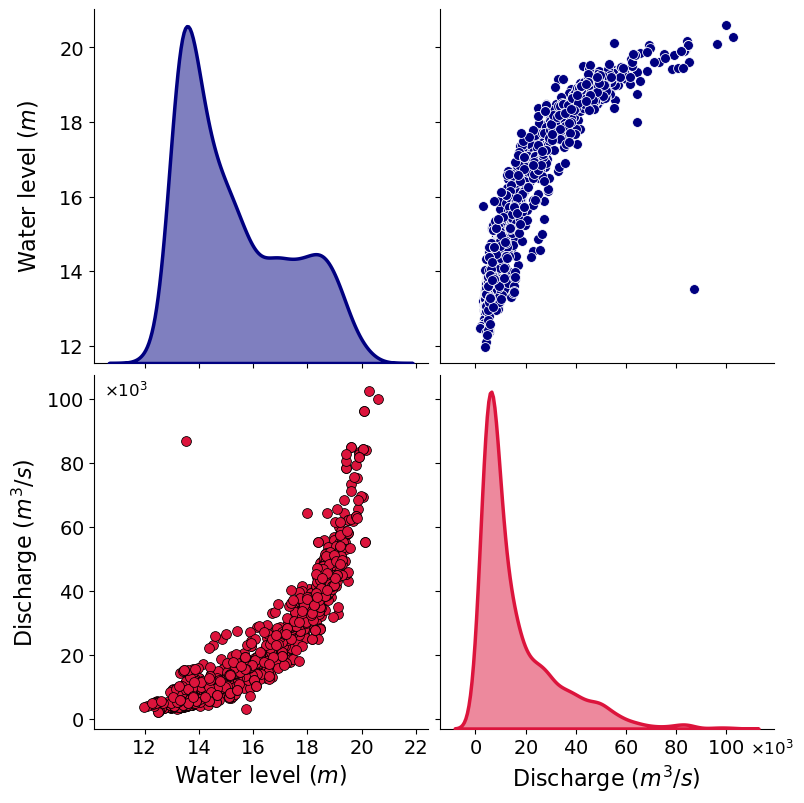

In [39]:
markers = ['o', 'P', 'X', '^', 's', 'D']
colors = ['navy', 'crimson'] 

df = pd.DataFrame({
    'Water level ($m$)': WL_Q_Umax_bi_Baha_90_16['Biweekly water level (m)'],
    'Discharge ($m^3/s$)': WL_Q_Umax_bi_Baha_90_16['Biweekly discharge ($m^3/s$)']
})

# Create pairplot figure
pairplot_fig = sns.pairplot(df, diag_kind='kde', height=4, plot_kws={'s': 75, 'color': 'navy', 'edgecolor': 'palegoldenrod'})

# Adjust KDE plot colors and line width on the diagonal
kde_linewidth = 2.5  # Set the desired line width
for i, ax in enumerate(pairplot_fig.diag_axes):
    color = mcolors.to_rgba(colors[i % len(colors)], alpha=0.5) 
    for kde in ax.collections:
        kde.set_edgecolor(colors[i % len(colors)])  
        kde.set_facecolor(color)  
        kde.set_linewidth(kde_linewidth)

# adjust scatter plot colors and markers on the off-diagonal
for i, ax in enumerate(pairplot_fig.axes.flatten()):
    # only proceed if ax is not None
    if ax is not None and i % len(df.columns) != i // len(df.columns):
        row = i // len(df.columns)
        col = i % len(df.columns)
        scatter_color = colors[row % len(colors)]  # change color based on row index
        
        ax.clear()  # Use clear() instead of removing artists
        
        # Plot new scatter plot
        if scatter_color != 'black' and scatter_color != 'navy':
            sns.scatterplot(x=df.iloc[:, col], y=df.iloc[:, row], zorder=2, ax=ax, color=scatter_color, edgecolor='black', s=50)
        else:
            sns.scatterplot(x=df.iloc[:, col], y=df.iloc[:, row], zorder=2, ax=ax, color=scatter_color, edgecolor='white', s=50)

        # sns.regplot(x=df.iloc[:, col], y=df.iloc[:, row], ax=ax, 
        #             scatter_kws={'s': 50, 'color': scatter_color, 'edgecolor': 'black'}, 
        #             line_kws={'color': 'palegoldenrod', 'lw': 2}, 
        #             order=2,  # Change to a higher degree for more complex curves
        #             ci=None)  # ci=None disables confidence intervals for the regression line
        
        # add correlation value annotation
        corr_pearson = df.corr().iloc[row, col]
        # ax.annotate(fr'$\rho$={corr_val:.2f}', xy=(0.7, 0.2), xycoords='axes fraction',
        #             ha='left', va='center', fontsize=13, color='navy',
        #             bbox=dict(boxstyle="round,pad=0.3", edgecolor='navy', facecolor=(1, 1, 1, 0.7)))
        corr_spearman = df.corr(method='spearman').iloc[row, col]
        # ax.annotate(fr'$\rho_s$={corr_val:.2f}', xy=(0.7, 0.1), xycoords='axes fraction',
        #             ha='left', va='center', fontsize=13, color='navy',
        #             bbox=dict(boxstyle="round,pad=0.3", edgecolor='navy', facecolor=(1, 1, 1, 0.7)))

for ax in pairplot_fig.axes.flatten():
    if ax is not None:
        ax.tick_params(axis='both', labelsize=14)  
        x_min, x_max = ax.get_xlim()
        y_min, y_max = ax.get_ylim()
        ax.get_yaxis().set_label_coords(-0.16,0.5)
        ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=7, prune='both')) 
        ax.yaxis.set_major_locator(ticker.MaxNLocator(nbins=6, prune='both')) 

        ax.set_xlabel(ax.get_xlabel(), fontsize=16)
        ax.set_ylabel(ax.get_ylabel(), fontsize=16)

        # ax.set_yticks(ax.get_xticks())

for ax in pairplot_fig.axes.flatten():
    for label in ax.get_xticklabels():
        ax.set_xlabel(ax.get_xlabel(), fontsize=16)
        ax.set_ylabel(ax.get_ylabel(), fontsize=16)

second_plot = pairplot_fig.axes[1, 1]  # access the second plot (first row, second column)
third_plot = pairplot_fig.axes[1, 0]
topr_plot = pairplot_fig.axes[0, 1]

# set x-axis to scientific notation using ScalarFormatter
formatter = ticker.ScalarFormatter(useMathText=True)
formatter.set_scientific(True)  # enable scientific notation
formatter.set_powerlimits((3, 3))  # This sets the range for when scientific notation is used (values above 10^3)
second_plot.xaxis.set_major_formatter(formatter)
third_plot.yaxis.set_major_formatter(formatter)

third_plot.yaxis.set_major_locator(ticker.MaxNLocator(nbins=6)) 
third_plot.yaxis.get_offset_text().set_x(-0.15)
third_plot.yaxis.get_offset_text().set_y(-0.55)

second_plot.annotate(fr'$\times10^3$',
                     xy=(0.93, -0.08),  # Position in axes fraction coordinates
                     xycoords='axes fraction',  # This ensures the annotation is relative to the axes
                     fontsize=12,  # Set the font size
                     ha='left', va='bottom') #bbox=dict(boxstyle="round,pad=0.3", edgecolor='white', facecolor='white', alpha=0.5)

third_plot.annotate(fr'$\times10^3$',
                     xy=(0.03, 0.99),  # Position in axes fraction coordinates
                     xycoords='axes fraction',  # This ensures the annotation is relative to the axes
                     fontsize=12,  # Set the font size
                     ha='left', va='top', bbox=dict(boxstyle="round,pad=0.3", edgecolor='white', facecolor='white'))

third_plot.annotate(fr'           ',
                     xy=(-0.2, 1.04),  # Position in axes fraction coordinates
                     xycoords='axes fraction',  # This ensures the annotation is relative to the axes
                     fontsize=12,  # Set the font size
                     ha='left', va='top', bbox=dict(boxstyle="round,pad=0.3", edgecolor='white', facecolor='white'))
second_plot.annotate(fr'           ',
                     xy=(0.89, -0.116),  # Position in axes fraction coordinates
                     xycoords='axes fraction',  # This ensures the annotation is relative to the axes
                     fontsize=12,  # Set the font size
                     ha='left', va='top', bbox=dict(boxstyle="round,pad=0.3", edgecolor='white', facecolor='white'))

# topr_plot.annotate(rf'$\rho={corr_pearson:.2f}$' + '\n' + fr'$\rho_s={corr_spearman:.2f}$',
#                      xy=(0.5, 0.5),  # Position in axes fraction coordinates
#                      xycoords='axes fraction',  # This ensures the annotation is relative to the axes
#                      fontsize=25, color='navy', fontproperties=cambria_font, # Set the font size
#                      ha='center', va='center', bbox=dict(boxstyle="round,pad=0.3", edgecolor='white', facecolor='white'))

# plt.savefig(rf'images\report\10_appendix\river\correlation_wlq.png', bbox_inches='tight', dpi=1500)
plt.show()
plt.close()

In [40]:
df_1992 = WL_Q_Umax_bi_Baha_90_16[WL_Q_Umax_bi_Baha_90_16['Date (yyyy-mm-dd)'].dt.year == 1992]

In [41]:
df_1992

,Date (yyyy-mm-dd),Biweekly water level (m),Biweekly discharge ($m^3/s$),Biweekly max velocity (m/s)
57,1992-01-06,14.22,7080.0,1.0
58,1992-01-20,13.95,6560.0,1.0
59,1992-02-03,13.86,5140.0,1.0
60,1992-02-17,13.86,4990.0,1.0
61,1992-03-02,13.77,4670.0,1.0
...,...,...,...,...
169,1992-12-27,14.07,6810.0,1.0
170,1992-12-28,14.05,6780.0,1.0
171,1992-12-29,14.02,6730.0,1.0
172,1992-12-30,14.02,6690.0,1.0


In [42]:
# only 1992

discharge_stats = df_1992['Biweekly discharge ($m^3/s$)'].describe(
    percentiles=[0.25, 0.5, 0.75, 0.90]
)

# Step 2: Extract the specific statistical values
min_1992 = discharge_stats['min']
q1_1992 = discharge_stats['25%']
median_1992 = discharge_stats['50%']
mean_1992 = discharge_stats['mean']
q3_1992 = discharge_stats['75%']
q90_1992 = discharge_stats['90%']
max_1992 = discharge_stats['max']

min_water_level = df_1992.loc[
    (df_1992['Biweekly discharge ($m^3/s$)'] - min_1992).abs().idxmin(),
    'Biweekly water level (m)'
]

q1_water_level = df_1992.loc[
    (df_1992['Biweekly discharge ($m^3/s$)'] - q1_1992).abs().idxmin(),
    'Biweekly water level (m)'
]

median_water_level = df_1992.loc[
    (df_1992['Biweekly discharge ($m^3/s$)'] - median_1992).abs().idxmin(),
    'Biweekly water level (m)'
]

mean_water_level = df_1992.loc[
    (df_1992['Biweekly discharge ($m^3/s$)'] - mean_1992).abs().idxmin(),
    'Biweekly water level (m)'
]

q3_water_level = df_1992.loc[
    (df_1992['Biweekly discharge ($m^3/s$)'] - q3_1992).abs().idxmin(),
    'Biweekly water level (m)'
]

q90_water_level = df_1992.loc[
    (df_1992['Biweekly discharge ($m^3/s$)'] - q90_1992).abs().idxmin(),
    'Biweekly water level (m)'
]

max_water_level = df_1992.loc[
    (df_1992['Biweekly discharge ($m^3/s$)'] - max_1992).abs().idxmin(),
    'Biweekly water level (m)'
]


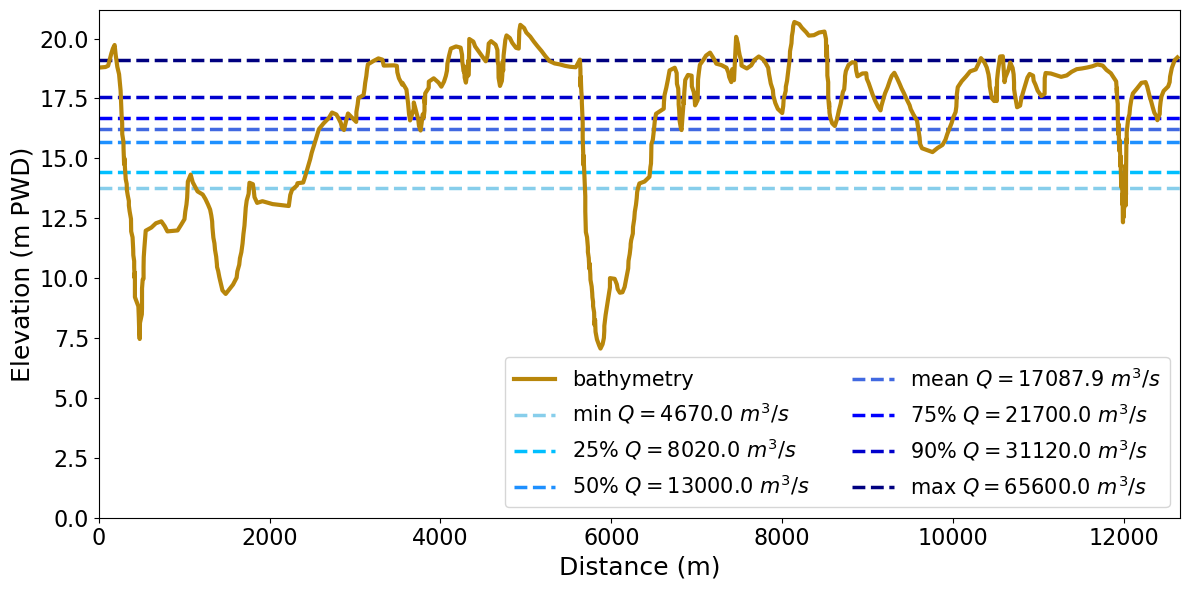

In [43]:
bath = pd.read_csv(r'data\bathymetry_1992.csv', header=0)
# bath.sort_values('X', inplace=True)
# wlplot = [np.min(WL_1993), np.percentile(WL_1993, 25), np.median(WL_1993), np.mean(WL_1993), np.percentile(WL_1993, 75), np.max(WL_1993)]
wlplot = [min_water_level, q1_water_level, median_water_level, mean_water_level, q3_water_level, q90_water_level, max_water_level]
colors = ['skyblue', 'deepskyblue', 'dodgerblue', 'royalblue', 'blue', 'mediumblue', 'navy']
legend = [fr'min $Q={min_1992:.1f}$ $m^3/s$', fr'25% $Q={q1_1992:.1f}$ $m^3/s$', f'50% $Q={median_1992:.1f}$ $m^3/s$', 
          f'mean $Q={mean_1992:.1f}$ $m^3/s$', f'75% $Q={q3_1992:.1f}$ $m^3/s$', f'90% $Q={q90_1992:.1f}$ $m^3/s$', f'max $Q={max_1992:.1f}$ $m^3/s$']
cmap = plt.get_cmap('inferno')
plt.figure(figsize=(12,6))
plt.plot(bath['X'], bath['Z'], zorder=2, color='darkgoldenrod', lw=3, label='bathymetry')
# for i in range(len(wlplot)):
#     plt.axhline(wlplot[i], color=colors[i], lw=2.5, ls='--', label=f'{legend[i]}')
for i in range(len(wlplot)):
    color = cmap(i / len(wlplot))  # Get color from colormap
    plt.axhline(wlplot[i], color=colors[i], zorder=1, lw=2.5, ls='--', label=legend[i])
plt.xlim([0, np.max(bath['X'])+30])
plt.ylim([0, np.max(bath['Z'])+0.5])
plt.legend(fontsize=15., ncol=2, loc='lower right')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel('Distance (m)', fontsize=18)
plt.ylabel('Elevation (m PWD)', fontsize=18)
plt.tight_layout()
# plt.savefig(r'images\report\2_literature\bath_clean_1992.png', bbox_inches='tight', dpi=300)
plt.show()
plt.close(fig)  # Close the figure to free memory

In [44]:
discharge_stats = WL_Q_Umax_bi_Baha_90_16['Biweekly discharge ($m^3/s$)'].describe(
    percentiles=[0.25, 0.5, 0.75, 0.90]
)

min_ = discharge_stats['min']
q1_ = discharge_stats['25%']
median_ = discharge_stats['50%']
mean_ = discharge_stats['mean']
q3_ = discharge_stats['75%']
q90_ = discharge_stats['90%']
max_ = discharge_stats['max']

# Step 3: Find the corresponding water levels for the statistical discharge values
# We will use `idxmin` and `idxmax` to find the row index of the closest values

min_water_level = WL_Q_Umax_bi_Baha_90_16.loc[
    (WL_Q_Umax_bi_Baha_90_16['Biweekly discharge ($m^3/s$)'] - min_).abs().idxmin(),
    'Biweekly water level (m)'
]

q1_water_level = WL_Q_Umax_bi_Baha_90_16.loc[
    (WL_Q_Umax_bi_Baha_90_16['Biweekly discharge ($m^3/s$)'] - q1_).abs().idxmin(),
    'Biweekly water level (m)'
]

median_water_level = WL_Q_Umax_bi_Baha_90_16.loc[
    (WL_Q_Umax_bi_Baha_90_16['Biweekly discharge ($m^3/s$)'] - median_).abs().idxmin(),
    'Biweekly water level (m)'
]

mean_water_level = WL_Q_Umax_bi_Baha_90_16.loc[
    (WL_Q_Umax_bi_Baha_90_16['Biweekly discharge ($m^3/s$)'] - mean_).abs().idxmin(),
    'Biweekly water level (m)'
]

q3_water_level = WL_Q_Umax_bi_Baha_90_16.loc[
    (WL_Q_Umax_bi_Baha_90_16['Biweekly discharge ($m^3/s$)'] - q3_).abs().idxmin(),
    'Biweekly water level (m)'
]

q90_water_level = WL_Q_Umax_bi_Baha_90_16.loc[
    (WL_Q_Umax_bi_Baha_90_16['Biweekly discharge ($m^3/s$)'] - q90_).abs().idxmin(),
    'Biweekly water level (m)'
]

max_water_level = WL_Q_Umax_bi_Baha_90_16.loc[
    (WL_Q_Umax_bi_Baha_90_16['Biweekly discharge ($m^3/s$)'] - max_).abs().idxmin(),
    'Biweekly water level (m)'
]

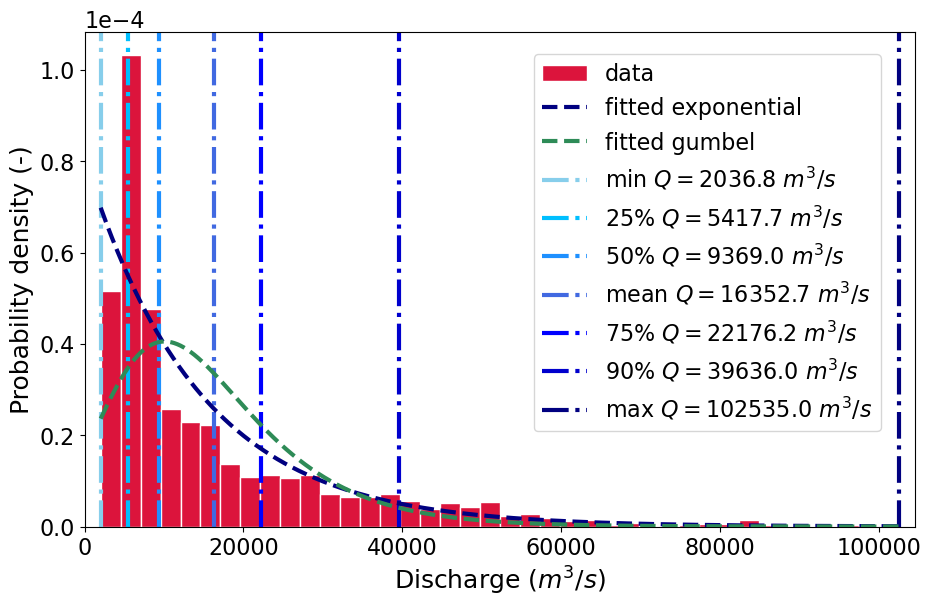

In [45]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import expon, gumbel_r

data = WL_Q_Umax_bi_Baha_90_16[r'Biweekly discharge ($m^3/s$)']

params = expon.fit(data)
loc, scale = params
x = np.linspace(np.min(data), np.max(data), 1000)
pdf_fitted = expon.pdf(x, loc=loc, scale=scale)

params_g = gumbel_r.fit(data)
loc_g, scale_g = params_g
pdf_fitted_g = gumbel_r.pdf(x, loc=loc_g, scale=scale_g)

discharge_stats = WL_Q_Umax_bi_Baha_90_16['Biweekly discharge ($m^3/s$)'].describe(
    percentiles=[0.25, 0.5, 0.75, 0.90]
)

min_ = discharge_stats['min']
q1_ = discharge_stats['25%']
median_ = discharge_stats['50%']
mean_ = discharge_stats['mean']
q3_ = discharge_stats['75%']
q90_ = discharge_stats['90%']
max_ = discharge_stats['max']

qplot = [min_, q1_, median_, mean_, q3_, q90_, max_]
colors = ['skyblue', 'deepskyblue', 'dodgerblue', 'royalblue', 'blue', 'mediumblue', 'navy']
legend = [fr'min $Q={min_:.1f}$ $m^3/s$', fr'25% $Q={q1_:.1f}$ $m^3/s$', f'50% $Q={median_:.1f}$ $m^3/s$', 
          f'mean $Q={mean_:.1f}$ $m^3/s$', f'75% $Q={q3_:.1f}$ $m^3/s$', f'90% $Q={q90_:.1f}$ $m^3/s$', f'max $Q={max_:.1f}$ $m^3/s$']

fig = plt.figure(figsize=(10, 6))

plt.hist(data, bins=40,zorder=2, density=True, color='crimson', edgecolor='white', label='data') #alpha=0.6, 
plt.plot(x, pdf_fitted, zorder=3, color='navy', ls='--', lw=3, label='fitted exponential')
plt.plot(x, pdf_fitted_g, zorder=3, color='seagreen', ls='--', lw=3, label='fitted gumbel')
for i in range(len((qplot))):
    plt.axvline(qplot[i], zorder=2, lw=3, color=colors[i], ls='-.', label=legend[i])
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel('Discharge ($m^3/s$)', fontsize=18)
plt.ylabel('Probability density (-)', fontsize=18)
plt.xlim([0,max_+2000])
plt.legend(fontsize=16, bbox_to_anchor=(0.75, 0.17))
plt.tight_layout()

ax = plt.gca()
ax.ticklabel_format(axis='y', style='sci', scilimits=(-1, 1))
ax.yaxis.get_offset_text().set_fontsize(16)


# plt.savefig(r'images\report\10_appendix\river\distributionQ.png', bbox_inches='tight', dpi=300)
plt.show()
plt.close(fig)  # Close 


K-S Test Statistic: 0.10145795660706591
p-value: 6.107038751150569e-19


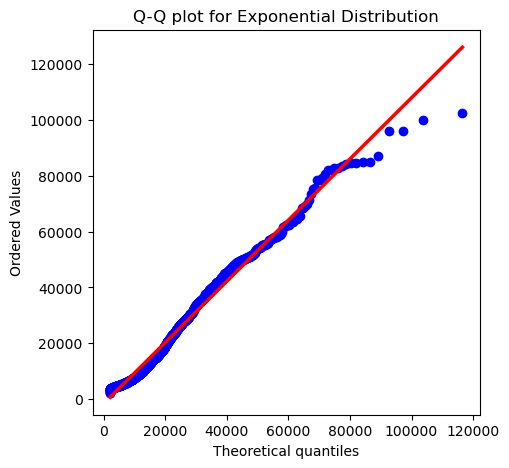

In [46]:
import scipy.stats as stats
import matplotlib.pyplot as plt

from scipy.stats import kstest

# Perform the K-S test
D, p_value = kstest(data, 'expon', args=(loc, scale))

print(f'K-S Test Statistic: {D}')
print(f'p-value: {p_value}')


# Q-Q plot
plt.figure(figsize=(5, 5))
stats.probplot(data, dist="expon", sparams=(loc, scale), plot=plt)

plt.title('Q-Q plot for Exponential Distribution')
plt.show()


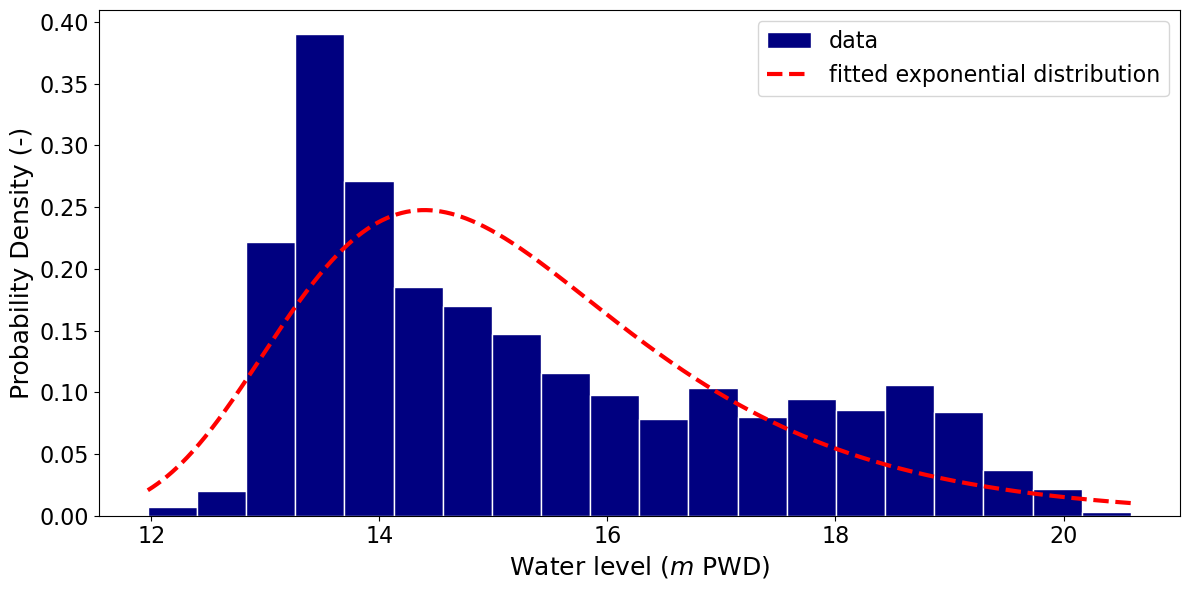

In [47]:
data = WL_Q_Umax_bi_Baha_90_16['Biweekly water level (m)']

params = gumbel_r.fit(data)
loc, scale = params
x = np.linspace(np.min(data), np.max(data), 1000)
pdf_fitted = gumbel_r.pdf(x, loc=loc, scale=scale)

fig = plt.figure(figsize=(12, 6))

plt.hist(data, bins=20, density=True, color='navy', edgecolor='white', label='data') 
plt.plot(x, pdf_fitted, 'r--', lw=3, label='fitted exponential distribution')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel('Water level ($m$ PWD)', fontsize=18)
plt.ylabel('Probability Density (-)', fontsize=18)
plt.legend(fontsize=16)
plt.tight_layout()

ax = plt.gca()
ax.ticklabel_format(axis='y', style='sci', scilimits=(-5, 5))
ax.yaxis.get_offset_text().set_fontsize(16)

# plt.savefig(r'images\report\10_appendix\river\distributionQ.png', bbox_inches='tight', dpi=300)
plt.show()

K-S Test Statistic: 0.4435288414929714
p-value: 0.0


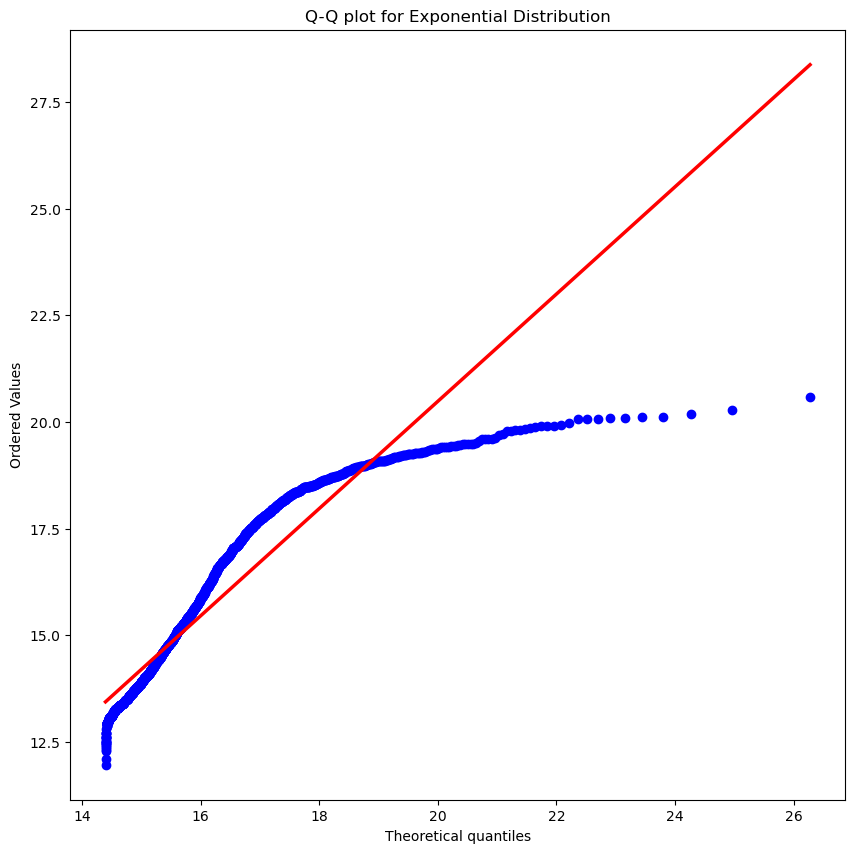

In [48]:
# Perform the K-S test
D, p_value = kstest(data, 'expon', args=(loc, scale))

print(f'K-S Test Statistic: {D}')
print(f'p-value: {p_value}')


# Q-Q plot
plt.figure(figsize=(10, 10))
stats.probplot(data, dist="expon", sparams=(loc, scale), plot=plt)
plt.title('Q-Q plot for Exponential Distribution')
plt.show()


In [49]:
# this code relates to overall values 

discharge_stats = WL_Q_Umax_bi_Baha_90_16['Biweekly discharge ($m^3/s$)'].describe(
    percentiles=[0.25, 0.5, 0.75, 0.90]
)

min_ = discharge_stats['min']
q1_ = discharge_stats['25%']
median_ = discharge_stats['50%']
mean_ = discharge_stats['mean']
q3_ = discharge_stats['75%']
q90_ = discharge_stats['90%']
max_ = discharge_stats['max']

# find corresponding water levels for the statistical discharge values
# `idxmin` to find the row index of the closest values

min_water_level = WL_Q_Umax_bi_Baha_90_16.loc[
    (WL_Q_Umax_bi_Baha_90_16['Biweekly discharge ($m^3/s$)'] - min_).abs().idxmin(),
    'Biweekly water level (m)'
]

q1_water_level = WL_Q_Umax_bi_Baha_90_16.loc[
    (WL_Q_Umax_bi_Baha_90_16['Biweekly discharge ($m^3/s$)'] - q1_).abs().idxmin(),
    'Biweekly water level (m)'
]

median_water_level = WL_Q_Umax_bi_Baha_90_16.loc[
    (WL_Q_Umax_bi_Baha_90_16['Biweekly discharge ($m^3/s$)'] - median_).abs().idxmin(),
    'Biweekly water level (m)'
]

mean_water_level = WL_Q_Umax_bi_Baha_90_16.loc[
    (WL_Q_Umax_bi_Baha_90_16['Biweekly discharge ($m^3/s$)'] - mean_).abs().idxmin(),
    'Biweekly water level (m)'
]

q3_water_level = WL_Q_Umax_bi_Baha_90_16.loc[
    (WL_Q_Umax_bi_Baha_90_16['Biweekly discharge ($m^3/s$)'] - q3_).abs().idxmin(),
    'Biweekly water level (m)'
]

q90_water_level = WL_Q_Umax_bi_Baha_90_16.loc[
    (WL_Q_Umax_bi_Baha_90_16['Biweekly discharge ($m^3/s$)'] - q90_).abs().idxmin(),
    'Biweekly water level (m)'
]

max_water_level = WL_Q_Umax_bi_Baha_90_16.loc[
    (WL_Q_Umax_bi_Baha_90_16['Biweekly discharge ($m^3/s$)'] - max_).abs().idxmin(),
    'Biweekly water level (m)'
]

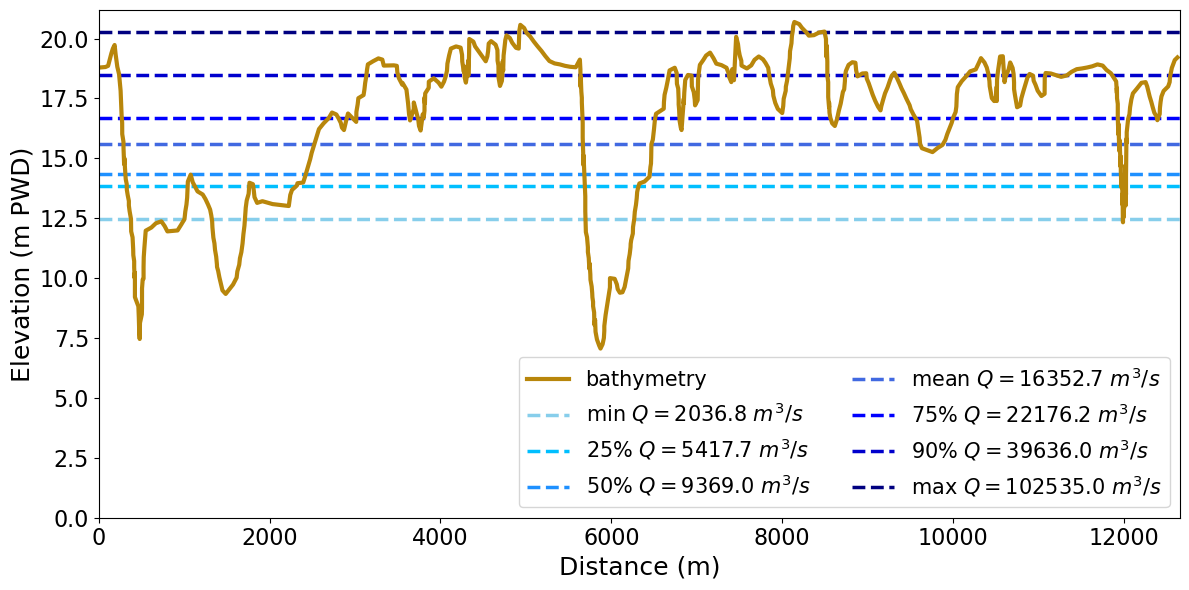

In [50]:
list_wl = [min_water_level, q1_water_level, median_water_level, mean_water_level, q3_water_level, q90_water_level, max_water_level]
list_q = [min_, q1_, median_, mean_, q3_, q90_, max_]
plot_bathymetry_WL(list_wl, list_q)

Location (mu): 14.39543807484968, Scale (beta): 1.4854785138422382


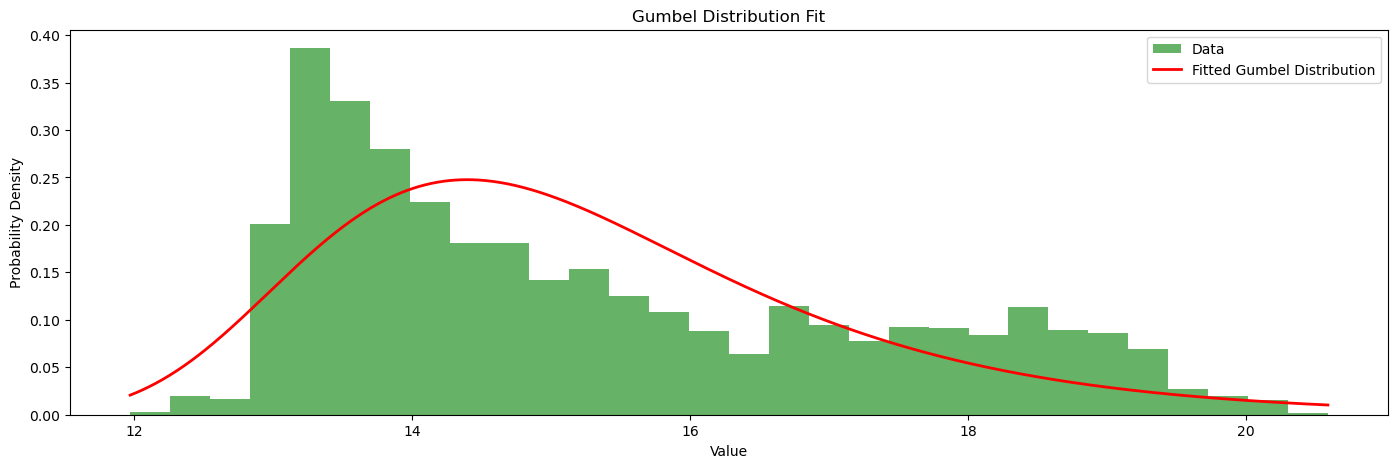

In [51]:
# fit Gumbel distribution
params = gumbel_r.fit(data)

# extract location (mu) and scale (beta) parameters
loc, scale = params
print(f"Location (mu): {loc}, Scale (beta): {scale}")

# generate values based on the fitted distribution
x = np.linspace(np.min(data), np.max(data), 1000)
pdf_fitted = gumbel_r.pdf(x, loc=loc, scale=scale)

# Plot histogram of the data
plt.hist(data, bins=30, density=True, alpha=0.6, color='g', label='Data')

# Plot the fitted Gumbel distribution
plt.plot(x, pdf_fitted, 'r-', lw=2, label='Fitted Gumbel Distribution')

plt.xlabel('Value')
plt.ylabel('Probability Density')
plt.legend()
plt.title('Gumbel Distribution Fit')
plt.show()

In [52]:
start_date = '1990-01-01'
end_date = '1990-12-31'
date_range = pd.date_range(start=start_date, end=end_date, freq='14D')
two_week_df = pd.DataFrame(date_range, columns=['Start'])
two_week_df['End'] = two_week_df['Start'] + pd.Timedelta(days=13)
two_week_df['Interval'] = pd.IntervalIndex.from_arrays(two_week_df['Start'], two_week_df['End'])
two_week_df['ID'] = two_week_df['Start'].dt.strftime('%m-%d').factorize()[0] + 1
two_week_df

def assign_id(date):
    # Extract just the month-day part of the date (ignoring the year)
    month_day = date.strftime('%m-%d')
    
    # Find the matching interval using the month-day
    matching_interval = two_week_df[two_week_df['Start'].dt.strftime('%m-%d') <= month_day]
    matching_interval = matching_interval[matching_interval['End'].dt.strftime('%m-%d') >= month_day]
    
    if not matching_interval.empty:
        return matching_interval['ID'].values[0]  # Return the corresponding ID
    return None  # Return None if no match is found

WL_Q_Umax_bi_Baha_90_16['ID'] = WL_Q_Umax_bi_Baha_90_16['Date (yyyy-mm-dd)'].apply(assign_id)

mean_values_wl = WL_Q_Umax_bi_Baha_90_16.groupby('ID')['Biweekly water level (m)'].mean().reset_index()
mean_values_q = WL_Q_Umax_bi_Baha_90_16.groupby('ID')['Biweekly discharge ($m^3/s$)'].mean().reset_index()

merged_df = pd.merge(mean_values_wl, mean_values_q, on='ID')
merged_df

,ID,Biweekly water level (m),Biweekly discharge ($m^3/s$)
0,1.0,13.658084,6006.350589
1,2.0,13.470046,5977.585872
2,3.0,13.335673,4870.779096
3,4.0,13.247500,4646.973646
4,5.0,13.324843,4845.685372
5,6.0,13.492411,5305.949131
6,7.0,14.138327,7433.908398
7,8.0,14.488089,8510.131357
8,9.0,15.174176,11118.227196
9,10.0,15.976104,15948.930198


In [53]:
df = WL_Q_Umax_bi_Baha_90_16.copy() 

In [54]:
new_rows = []

for i in range(len(df) - 1):
    current_row = df.iloc[i]
    next_row = df.iloc[i + 1]
    
    # Add current row to the new rows list
    new_rows.append(current_row)
    if next_row['ID'] != current_row['ID'] > 1:
        missing_id = current_row['ID'] + 1
        
        # FIND missing ID's corresponding date and average values from the precomputed dataframe
        avg_row = merged_df[merged_df['ID'] == missing_id]
        
        # if not avg_row.empty:
        #     # Create a new row with the missing ID
        #     new_row = {
        #         'Date (yyyy-mm-dd)': pd.to_datetime(f"{current_row['Date (yyyy-mm-dd)'].year}-{current_row['2-Week Period']}"),  # NaT (Not a Time) to indicate missing date
        #         'Biweekly water level (m)': avg_row['Biweekly water level (m)'].values[0],
        #         'Biweekly discharge ($m^3/s$)': avg_row['Biweekly discharge ($m^3/s$)'].values[0],
        #         '2-Week Period': df['2-Week Period'][df['ID'] == missing_id].values[0],  # Copy from original data based on ID
        #         'ID': missing_id
        #     }
        #     # Append the newly created row to the list
        #     new_rows.append(new_row)

In [55]:
new_df = pd.DataFrame(new_rows)

# add last row from the original dataframe (since the loop stops one before the last row)
new_df = new_df.append(df.iloc[-1], ignore_index=True)
# reset index of the new dataframe
new_df = new_df.reset_index(drop=True)

print(new_df)

     Date (yyyy-mm-dd)  Biweekly water level (m)  \
0           1990-01-08                     14.00   
1           1990-01-22                     13.77   
2           1990-02-05                     13.71   
3           1990-02-19                     13.77   
4           1990-03-05                     13.86   
...                ...                       ...   
2058        2016-10-25                     16.86   
2059        2016-11-08                     15.15   
2060        2016-11-23                     14.36   
2061        2016-12-06                     13.77   
2062        2016-12-19                     13.29   

      Biweekly discharge ($m^3/s$)  Biweekly max velocity (m/s)    ID  
0                          6480.00                         1.00   1.0  
1                          5930.00                         1.00   2.0  
2                          5340.00                         1.00   3.0  
3                          5510.00                         1.00   4.0  
4              

In [56]:
WL_Q_Umax_bi_Baha_90_16['Date (yyyy-mm-dd)'] = pd.to_datetime(WL_Q_Umax_bi_Baha_90_16['Date (yyyy-mm-dd)'])

In [57]:
mean_wl = []
mean_q = []

for interval in two_week_df['Interval']:
    wl = WL_Q_Umax_bi_Baha_90_16[(WL_Q_Umax_bi_Baha_90_16['Date (yyyy-mm-dd)'] >= interval.left) & (
        WL_Q_Umax_bi_Baha_90_16['Date (yyyy-mm-dd)'] <= interval.right)]['Biweekly water level (m)']
    q = WL_Q_Umax_bi_Baha_90_16[(WL_Q_Umax_bi_Baha_90_16['Date (yyyy-mm-dd)'] >= interval.left) & (
        WL_Q_Umax_bi_Baha_90_16['Date (yyyy-mm-dd)'] <= interval.right)]['Biweekly discharge ($m^3/s$)']
    
    if not wl.empty:
        mean_wl.append(wl.mean())
    else:
        mean_wl.append(np.nan)
    
    if not q.empty:
        mean_q.append(q.mean())
    else:
        mean_q.append(np.nan)